# Text classification with movie reviews

In [1]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

1.11.0


## Download the IMDB dataset

The IMDB dataset comes packaged with TensorFlow. It has already been preprocessed such that the reviews (sequences of words) have been converted to sequences of integers, where each integer represents a specific word in a dictionary.

In [2]:
imdb = keras.datasets.imdb

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

## Explore the data

In [3]:
print("Training entries: {}, labels: {}".format(len(train_data), len(train_labels)))

Training entries: 25000, labels: 25000


In [4]:
print(train_data[0])

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]


In [5]:
len(train_data[0]), len(train_data[1])

(218, 189)

In [6]:
# A dictionary mapping words to an integer index
word_index = imdb.get_word_index()

# The first indices are reserved
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  # unknown
word_index["<UNUSED>"] = 3

#reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
reverse_word_index = {value: key for (key, value) in word_index.items()}

def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [7]:
decode_review(train_data[0])

"<START> this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert <UNK> is an amazing actor and now the same being director <UNK> father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for <UNK> and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also <UNK> to the two little boy's that played the <UNK> of norman and paul they were just brilliant children are often left out of the <UNK> list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

In [8]:
list(word_index.items())[:10]

[('fawn', 34704),
 ('tsukino', 52009),
 ('nunnery', 52010),
 ('sonja', 16819),
 ('vani', 63954),
 ('woods', 1411),
 ('spiders', 16118),
 ('hanging', 2348),
 ('woody', 2292),
 ('trawling', 52011)]

## Prepare the data

The reviews—the arrays of integers—must be converted to tensors before fed into the neural network. This conversion can be done a couple of ways:

- One-hot-encode the arrays to convert them into vectors of 0s and 1s. For example, the sequence [3, 5] would become a 10,000-dimensional vector that is all zeros except for indices 3 and 5, which are ones. Then, make this the first layer in our network—a Dense layer—that can handle floating point vector data. This approach is memory intensive, though, requiring a num_words * num_reviews size matrix.

- Alternatively, we can pad the arrays so they all have the same length, then create an integer tensor of shape max_length * num_reviews. We can use an embedding layer capable of handling this shape as the first layer in our network.

In [9]:
review_len = [len(x) for x in train_data]
max(review_len)

2494

In [10]:
np.median(review_len)

178.0

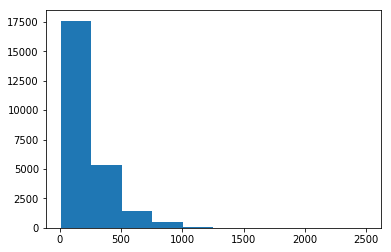

In [11]:
plt.figure()
plt.hist(review_len)
plt.grid(False)

In [12]:
train_data = keras.preprocessing.sequence.pad_sequences(train_data,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

test_data = keras.preprocessing.sequence.pad_sequences(test_data,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

In [13]:
len(train_data[0]), len(train_data[1])

(256, 256)

In [14]:
print(train_data[0])

[   1   14   22   16   43  530  973 1622 1385   65  458 4468   66 3941
    4  173   36  256    5   25  100   43  838  112   50  670    2    9
   35  480  284    5  150    4  172  112  167    2  336  385   39    4
  172 4536 1111   17  546   38   13  447    4  192   50   16    6  147
 2025   19   14   22    4 1920 4613  469    4   22   71   87   12   16
   43  530   38   76   15   13 1247    4   22   17  515   17   12   16
  626   18    2    5   62  386   12    8  316    8  106    5    4 2223
 5244   16  480   66 3785   33    4  130   12   16   38  619    5   25
  124   51   36  135   48   25 1415   33    6   22   12  215   28   77
   52    5   14  407   16   82    2    8    4  107  117 5952   15  256
    4    2    7 3766    5  723   36   71   43  530  476   26  400  317
   46    7    4    2 1029   13  104   88    4  381   15  297   98   32
 2071   56   26  141    6  194 7486   18    4  226   22   21  134  476
   26  480    5  144   30 5535   18   51   36   28  224   92   25  104
    4 

In [15]:
train_data.shape

(25000, 256)

In [16]:
len(word_index)

88588

## Build the model

In [17]:
# input shape is the vocabulary count used for the movie reviews (10,000 words)
vocab_size = 10000

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, 16))
model.add(keras.layers.GlobalAveragePooling1D())
model.add(keras.layers.Dense(16, activation=tf.nn.relu))
model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160000    
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 160,289
Trainable params: 160,289
Non-trainable params: 0
_________________________________________________________________


The layers are stacked sequentially to build the classifier:

1. The first layer is an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).
2. Next, a GlobalAveragePooling1D layer returns a fixed-length output vector for each example by averaging over the sequence dimension. This allows the model to handle input of variable length, in the simplest way possible.
3. This fixed-length output vector is piped through a fully-connected (Dense) layer with 16 hidden units.
4. The last layer is densely connected with a single output node. Using the sigmoid activation function, this value is a float between 0 and 1, representing a probability, or confidence level.

Loss function

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), we'll use the binary_crossentropy loss function.

This isn't the only choice for a loss function, you could, for instance, choose mean_squared_error. But, generally, binary_crossentropy is better for dealing with probabilities—it measures the "distance" between probability distributions, or in our case, between the ground-truth distribution and the predictions.

In [18]:
model.compile(optimizer=tf.train.AdamOptimizer(), # 'adam'
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Create a validation set

When training, we want to check the accuracy of the model on data it hasn't seen before. Create a validation set by setting apart 10,000 examples from the original training data. (Why not use the testing set now? Our goal is to develop and tune our model using only the training data, then use the test data just once to evaluate our accuracy).

In [19]:
x_val = train_data[:10000]
partial_x_train = train_data[10000:]

y_val = train_labels[:10000]
partial_y_train = train_labels[10000:]

## Train the model

In [20]:
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(x_val, y_val),
                    verbose=1)

Train on 15000 samples, validate on 10000 samples
Epoch 1/40
15000/15000 [==============================] - 2s 118us/step - loss: 0.6918 - acc: 0.5478 - val_loss: 0.6896 - val_acc: 0.6191
Epoch 2/40
15000/15000 [==============================] - 1s 90us/step - loss: 0.6853 - acc: 0.6881 - val_loss: 0.6809 - val_acc: 0.7499
Epoch 3/40
15000/15000 [==============================] - 2s 102us/step - loss: 0.6721 - acc: 0.7626 - val_loss: 0.6646 - val_acc: 0.7542
Epoch 4/40
15000/15000 [==============================] - 2s 106us/step - loss: 0.6489 - acc: 0.7742 - val_loss: 0.6389 - val_acc: 0.7580
Epoch 5/40
15000/15000 [==============================] - 2s 109us/step - loss: 0.6146 - acc: 0.7935 - val_loss: 0.6024 - val_acc: 0.7844
Epoch 6/40
15000/15000 [==============================] - 2s 107us/step - loss: 0.5707 - acc: 0.8113 - val_loss: 0.5593 - val_acc: 0.8042
Epoch 7/40
15000/15000 [==============================] - 2s 101us/step - loss: 0.5211 - acc: 0.8325 - val_loss: 0.5143 - v

## Evaluate the model

In [21]:
results = model.evaluate(test_data, test_labels)

print(results)

25000/25000 [==============================] - 1s 34us/step
[0.33563006547927854, 0.87144]


## Create a graph of accuracy and loss over time

In [22]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [ ]:
def plot

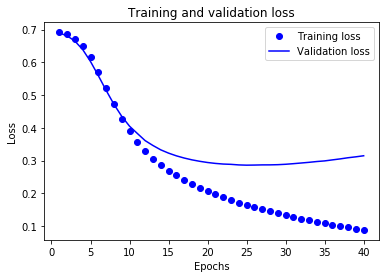

In [25]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

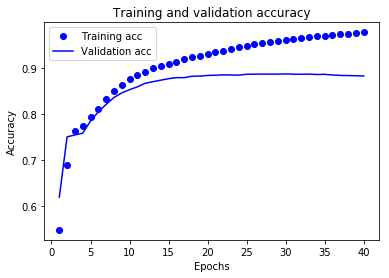

In [24]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [26]:
def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

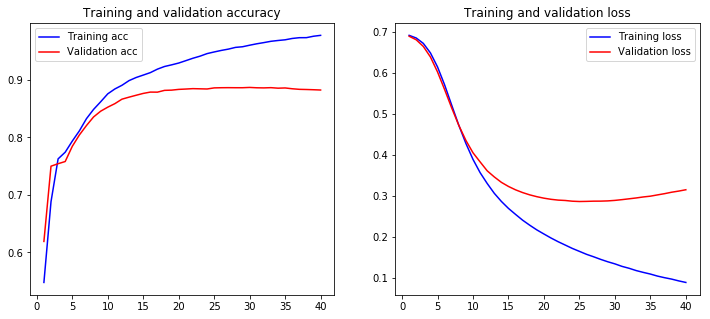

In [27]:
plot_history(history)